In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared,Calzetti

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [2]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
lzDB = galDB.query('z_grism < 1.5')
mzDB = galDB.query('1.5 < z_grism < 1.8')
hzDB = galDB.query('1.8 < z_grism < 2.1')
uhzDB = galDB.query('2.1 < z_grism')

BFs = pd.read_pickle('../dataframes/BF_fit_all.pkl')
lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
bfZ, bfd, bft, bftau, bfz, gids = [[],[],[],[],[],[]]

for i in BFs.index:
    bfZ.append(BFs.bfZ[i])
    bft.append(BFs.bft[i])
    bftau.append(BFs.bftau[i])
    bfz.append(np.round(BFs.bfz[i],3))
    bfd.append(np.round(BFs.bfd[i],1))
    gids.append(int(BFs.gids[i]))
    
bfZ = np.array(bfZ)
bft = np.array(bft)
bftau = np.array(bftau)
bfz = np.array(bfz)
bfd = np.array(bfd)
gids = np.array(gids)

In [4]:
data_path = '../data/'
model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
chi_path = '../chidat/'
spec_path = '../spec_files/'
beam_path = '../beams/'
template_path = '../templates/'
out_path = '../data/posteriors/'
phot_path = '../phot/'

def L_nu_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    lam_0 = lam / (1 + z) # restframe wavelenth in angstrom
    dust = 10**(-0.4*Av)
    return ((lam_0**2)/(c * m_star)) * l_aa * dust * 3.839E33

def F_nu_per_M(l_aa, lam, z, Av, m_star):
    conv = 3.086E24 # conversion of Mpc to cm
    D_l = cosmo.luminosity_distance(z).value # in Mpc
    return (1 + z) * L_nu_per_M(l_aa, lam, z, Av, m_star)  / (4 * np.pi * (D_l*conv)**2)

def F_lam_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)

def P(F,x):
    F = np.array(F).astype(np.float128)
    return np.exp(-np.array(F) / 2) / np.trapz(np.exp(-np.array(F) / 2),x)

class Gen_spec2(object):
    def __init__(self, field, galaxy_id, specz, g102_beam, g141_beam,
                 g102_lims = [7900, 11300], g141_lims = [11100, 16000],
                 filter_102 = 201, filter_141 = 203, tmp_err = False, 
                 phot_errterm = 0):
        self.field = field
        self.galaxy_id = galaxy_id
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.g102_lims = g102_lims
        self.g141_lims = g141_lims
        
        """
        B - prefix refers to g102
        R - prefix refers to g141
        P - prefix refers to photometry
        
        field - GND/GSD/UDS
        galaxy_id - ID number from 3D-HST
        specz - z_grism
        g102_lims - window for g102
        g141_lims - window for g141
        tmp_err - (flag) whether or not we apply a template error function (not available)
        """
        self.Bwv, self.Bflx, self.Berr, self.Bflt = np.load(spec_path + '{0}_{1}_g102.npy'.format(field, galaxy_id))
        self.Rwv, self.Rflx, self.Rerr, self.Rflt = np.load(spec_path + '{0}_{1}_g141.npy'.format(field, galaxy_id))
        self.Bmask = np.load(spec_path + 'spec_mask/{0}_{1}_g102_mask.npy'.format(field, galaxy_id))
        self.Rmask = np.load(spec_path + 'spec_mask/{0}_{1}_g141_mask.npy'.format(field, galaxy_id))
        
        self.Bwv = self.Bwv[self.Bmask]
        self.Bflt = self.Bflt[self.Bmask]
        self.Bflx = self.Bflx[self.Bmask]
        self.Berr = self.Berr[self.Bmask] 
        
        self.Rwv = self.Rwv[self.Rmask]
        self.Rflt = self.Rflt[self.Rmask]
        self.Rflx = self.Rflx[self.Rmask]
        self.Rerr = self.Rerr[self.Rmask] 
        
        self.Pwv, self.Pflx, self.Perr, self.Pnum = np.load(phot_path + '{0}_{1}_phot.npy'.format(field, galaxy_id))
        self.Pwv_rf = self.Pwv / (1 + self.specz)
                
        self.IDB = [U for U in range(len(self.Bwv)) if g102_lims[0] <= self.Bwv[U] <= g102_lims[-1] and self.Bflx[U]**2 > 0]
        self.IDR = [U for U in range(len(self.Rwv)) if g141_lims[0] <= self.Rwv[U] <= g141_lims[-1] and self.Rflx[U]**2 > 0]

        self.Bwv = self.Bwv[self.IDB]
        self.Bwv_rf = self.Bwv / (1 + specz)
        self.Bflt = self.Bflt[self.IDB]
        self.Bflx = self.Bflx[self.IDB] 
        self.Berr = self.Berr[self.IDB] 
        
        self.Rwv = self.Rwv[self.IDR]
        self.Rwv_rf = self.Rwv / (1 + specz)
        self.Rflt = self.Rflt[self.IDR]
        self.Rflx = self.Rflx[self.IDR]
        self.Rerr = self.Rerr[self.IDR] 

        self.model_photDF = pd.read_pickle(phot_path + 'model_photometry_list.pkl')
        
        self.IDP = []
        for i in range(len(self.Pnum)):
            for ii in range(len(self.model_photDF)):
                if self.Pnum[i] == self.model_photDF.tmp_num[self.model_photDF.index[ii]]:
                    self.IDP.append(ii)
               
        if tmp_err:
            WV,TEF = np.load(template_path + 'template_error_test.npy')
            iTEF = interp1d(WV,TEF)(self.Bwv_rf)
            self.Berr = np.sqrt(self.Berr**2 + (iTEF*self.Bflx)**2)

            iTEF = interp1d(WV,TEF)(self.Rwv_rf)
            self.Rerr = np.sqrt(self.Rerr**2 + (iTEF*self.Rflx)**2)
            
            iTEF = interp1d(WV,TEF)(self.Pwv_rf)
            self.Perr = np.sqrt(self.Perr**2 + (iTEF * self.Pflx)**2+ (phot_errterm * self.Pflx)**2)
                
                
        self.Bbeam = model.BeamCutout(fits_file = g102_beam)
        self.Rbeam = model.BeamCutout(fits_file = g141_beam)

        self.Bpoint_beam = model.BeamCutout(fits_file = '../beams/o149.0_41086.g102.A.fits')
        self.Rpoint_beam = model.BeamCutout(fits_file = '../beams/o185.0_41086.g141.A.fits')
        
        ### Define precalculated terms for photometry
        self.sens_wv, self.trans = np.load(template_path + 'master_tmp.npy')
        self.b = np.load(template_path + 'bottom_precalc.npy')
        self.dnu = np.load(template_path + 'dnu_precalc.npy')
        self.adj = np.load(template_path + 'adj_precalc.npy')
        self.mdleffwv = np.load(template_path + 'effwv_precalc.npy') 
    
        ### Set transmission curve
        model_wave, model_flux = np.load(model_path + 'm0.019_a2.0_dt0_spec.npy')
        Bw,Bfl = self.Sim_spec_indv(self.Bbeam, model_wave, np.ones(len(model_wave)))
        Rw,Rfl = self.Sim_spec_indv(self.Rbeam, model_wave, np.ones(len(model_wave)))
        self.Btrans = interp1d(Bw,Bfl)(self.Bwv)       
        self.Rtrans = interp1d(Rw,Rfl)(self.Rwv) 
    
        Bpmw,Bpmfl = self.Sim_spec_indv(self.Bpoint_beam, model_wave, np.ones(len(model_wave)))
        Rpmw,Rpmfl = self.Sim_spec_indv(self.Rpoint_beam, model_wave, np.ones(len(model_wave)))
        self.Bptrans = interp1d(Bpmw,Bpmfl)(self.Bwv)       
        self.Rptrans = interp1d(Rpmw,Rpmfl)(self.Rwv) 
    
    def Sim_spec_indv(self, BEAM, model_wave, model_flux):
        ### creates a model using an individual beam
        BEAM.beam.compute_model(spectrum_1d=[model_wave, model_flux])
        w, f, e = BEAM.beam.optimal_extract(BEAM.beam.model, bin=0)
        return w, f
        
    def Sim_spec_mult(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bbeam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rbeam, model_wave, model_flux)

    def Sim_spec_mult_point(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bpoint_beam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rpoint_beam, model_wave, model_flux)
    
    def Sim_spec(self, metal, age, tau, model_redshift = 0, Av = 0, multi_component = False,
                point_scale=1):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave * (1 + model_redshift), 
                                                                        model_flux * Calzetti(Av,model_wave))
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     
        
        self.Bmfl = iBmf / self.Btrans
        self.Rmfl = iRmf / self.Rtrans
            
        self.Bmfl *= self.PC
        self.Rmfl *= self.PC
        
        Bscale = Scale_model(self.Bflx, self.Berr, self.Bmfl)
        Rscale = Scale_model(self.Rflx, self.Rerr, self.Rmfl)
        
        self.Bflx = self.Bflx / Bscale ; self.Berr = self.Berr / Bscale 
        self.Rflx = self.Rflx / Rscale ; self.Rerr = self.Rerr / Rscale 
        
        if multi_component:
            [Bpmw, Bpmf], [Rpmw, Rpmf] = self.Sim_spec_mult_point(model_wave * (1 + model_redshift), 
                                                                            model_flux * Calzetti(Av,model_wave))
            iBpmf = interp1d(Bpmw,Bpmf)(self.Bwv)       
            iRpmf = interp1d(Rpmw,Rpmf)(self.Rwv)     

            self.Bpmfl = iBpmf / self.Bflt
            self.Rpmfl = iRpmf / self.Rflt

            self.Bpmfl *= Scale_model(self.Bflx, self.Berr, self.Bpmfl)
            self.Rpmfl *= Scale_model(self.Rflx, self.Rerr, self.Rpmfl)
            
            self.Bpmfl *= point_scale
            self.Rpmfl *= point_scale
            
            self.BMCmfl = self.Bmfl + self.Bpmfl
            self.RMCmfl = self.Rmfl + self.Rpmfl
            
            self.BMCmfl *= Scale_model(self.Bflx, self.Berr, self.BMCmfl)
            self.RMCmfl *= Scale_model(self.Rflx, self.Rerr, self.RMCmfl)
       
    def Sim_phot_mult(self, model_wave, model_flux):
        
        imfl =interp1d(self.c / model_wave, (self.c/(self.c / model_wave)**2) * model_flux)

        mphot = (np.trapz(imfl(self.c /(self.sens_wv[self.IDP])).reshape([len(self.IDP),len(self.sens_wv[0])]) \
                          * self.b[self.IDP],self.dnu[self.IDP])/np.trapz(self.b[self.IDP],
                                                                          self.dnu[self.IDP])) * self.adj[self.IDP]
        
        return np.array([self.mdleffwv[self.IDP],mphot])

    def Sim_phot(self, metal, age, tau, model_redshift = 0, Av = 0):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))
        
        self.Pmwv, self.Pmfl = self.Sim_phot_mult(model_wave * (1 + model_redshift), 
                                                  model_flux * Calzetti(Av,model_wave))
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)  
        self.Pmfl = self.Pmfl * self.PC
        
    def Sim_all(self, metal, age, tau, model_redshift = 0, Av = 0):
        self.Sim_phot(metal, age, tau, model_redshift, Av)
        self.Sim_spec(metal, age, tau, model_redshift, Av)

    def Sim_all_test(self, model_wave, model_flux):
        self.Sim_phot_test(model_wave, model_flux)
        self.Sim_spec_test(model_wave, model_flux)
        
    def Sim_phot_test(self, model_wave, model_flux):

        self.Pmwv, self.Pmfl = self.Sim_phot_mult(model_wave, model_flux )
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)  
        self.Pmfl = self.Pmfl * self.PC
        
    def Sim_spec_test(self, model_wave, model_flux):

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave, model_flux)
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     
        
        self.Bmfl = iBmf / self.Btrans
        self.Rmfl = iRmf / self.Rtrans
            
        self.Bmfl *= self.PC
        self.Rmfl *= self.PC
        
        #####
        [Bpmw, Bpmf], [Rpmw, Rpmf] = self.Sim_spec_mult_point(model_wave, model_flux)
        iBpmf = interp1d(Bpmw,Bpmf)(self.Bwv)       
        iRpmf = interp1d(Rpmw,Rpmf)(self.Rwv)     
        
        self.Bpmfl = iBpmf / self.Bptrans
        self.Rpmfl = iRpmf / self.Rptrans
            
        self.Bpmfl *= self.PC
        self.Rpmfl *= self.PC
        
    def Scale_flux(self, bfZ, bft, bftau, bfz, bfd):
        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(bfZ, bft, bftau))
        
        US_model_flux = F_lam_per_M(model_flux * Calzetti(bfd,model_wave), model_wave * (1 + bfz), bfz, 0, 1)

        US_pwv, US_pfl = self.Sim_phot_mult(model_wave * (1 + bfz), US_model_flux)
        
        self.mass = Scale_model(self.Pflx, self.Perr, US_pfl)
        
        self.lmass = np.log10(self.mass)
        
        self.model_wave = model_wave
        self.S_model_flux = US_model_flux * self.mass
          
        Bw,Bf = self.Sim_spec_indv(self.Bbeam, self.model_wave * (1 + bfz), self.S_model_flux)
        Rw,Rf = self.Sim_spec_indv(self.Rbeam, self.model_wave * (1 + bfz), self.S_model_flux)
        
        iBmf = interp1d(Bw,Bf)(self.Bwv)       
        iRmf = interp1d(Rw,Rf)(self.Rwv)  
  
        Bmfl = iBmf / self.Btrans
        Rmfl = iRmf /self.Rtrans

        self.Bscale = Scale_model(self.Bflx, self.Berr, Bmfl)
        self.Rscale = Scale_model(self.Rflx, self.Rerr, Rmfl)
        
        self.Bflx = self.Bflx / self.Bscale ; self.Berr = self.Berr / self.Bscale 
        self.Rflx = self.Rflx / self.Rscale ; self.Rerr = self.Rerr / self.Rscale         

In [137]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.002/0.019), sfh = 4, tau = 0.6)
sp2 = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.002/0.019), sfh = 4, tau = 0.6, 
                            add_neb_emission=1)

In [7]:
idx=30
bfZ[gids == galDB.ids[idx]][0], bft[gids == galDB.ids[idx]][0],bftau[gids == galDB.ids[idx]][0],bfz[gids == galDB.ids[idx]][0], bfd[gids == galDB.ids[idx]][0]

(0.002, 3.6, 8.78, 1.626, 0.6)

In [72]:
sp2.params['gas_logz'] = -0.6
sp2.params['gas_logu'] = -2.5

In [140]:
sp.params['add_neb_emission'] = 1
wv, fl = sp.get_spectrum(tage = 3.6, peraa = True)
sp.params['add_neb_emission'] = 0

wv2, fl2 = sp.get_spectrum(tage = 3.6, peraa = True)

cal = Calzetti(0.6, wv)

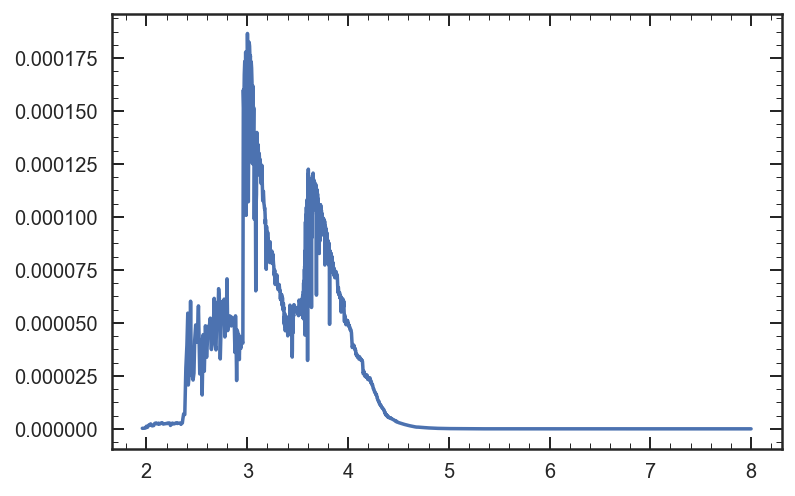

In [142]:
# plt.plot(np.log10(wv),fl)
plt.plot(np.log10(wv2),fl2)

In [75]:
idx = 30

Gs = Gen_spec2(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300],) 
Gs.Scale_flux(bfZ[gids == galDB.ids[idx]][0], bft[gids == galDB.ids[idx]][0],bftau[gids == galDB.ids[idx]][0],
                            bfz[gids == galDB.ids[idx]][0], bfd[gids == galDB.ids[idx]][0])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


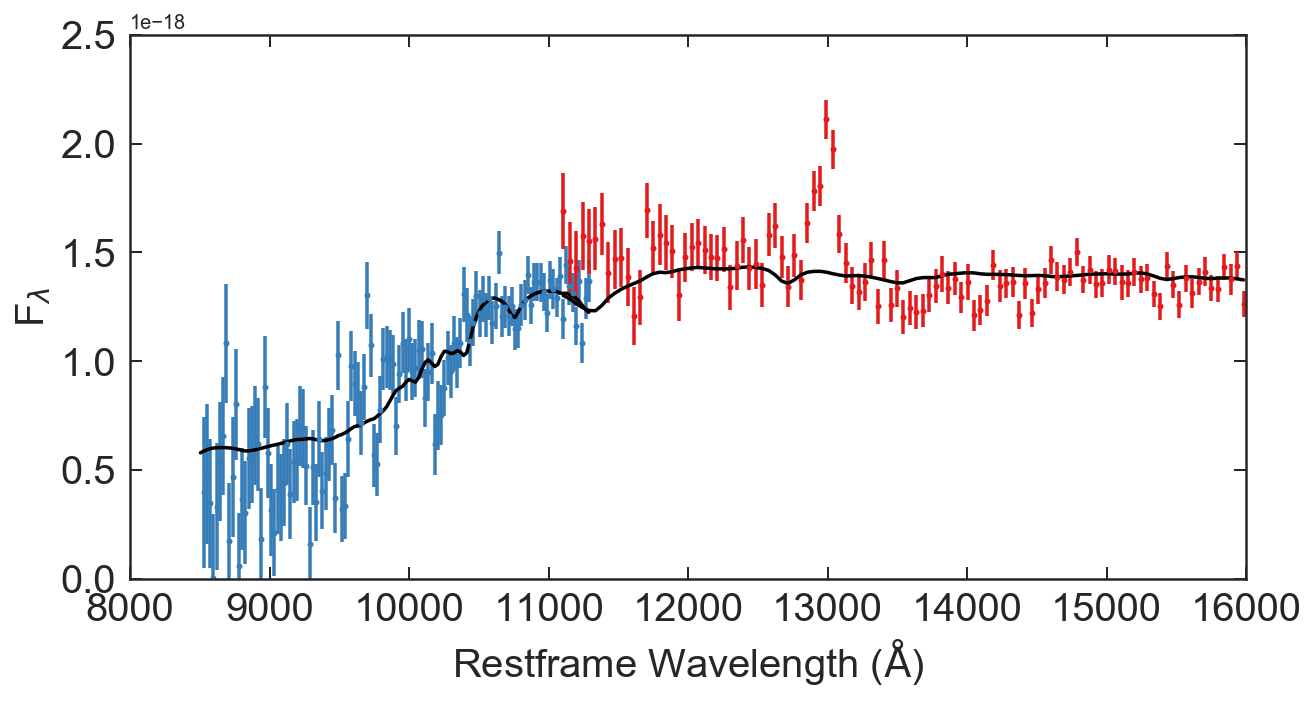

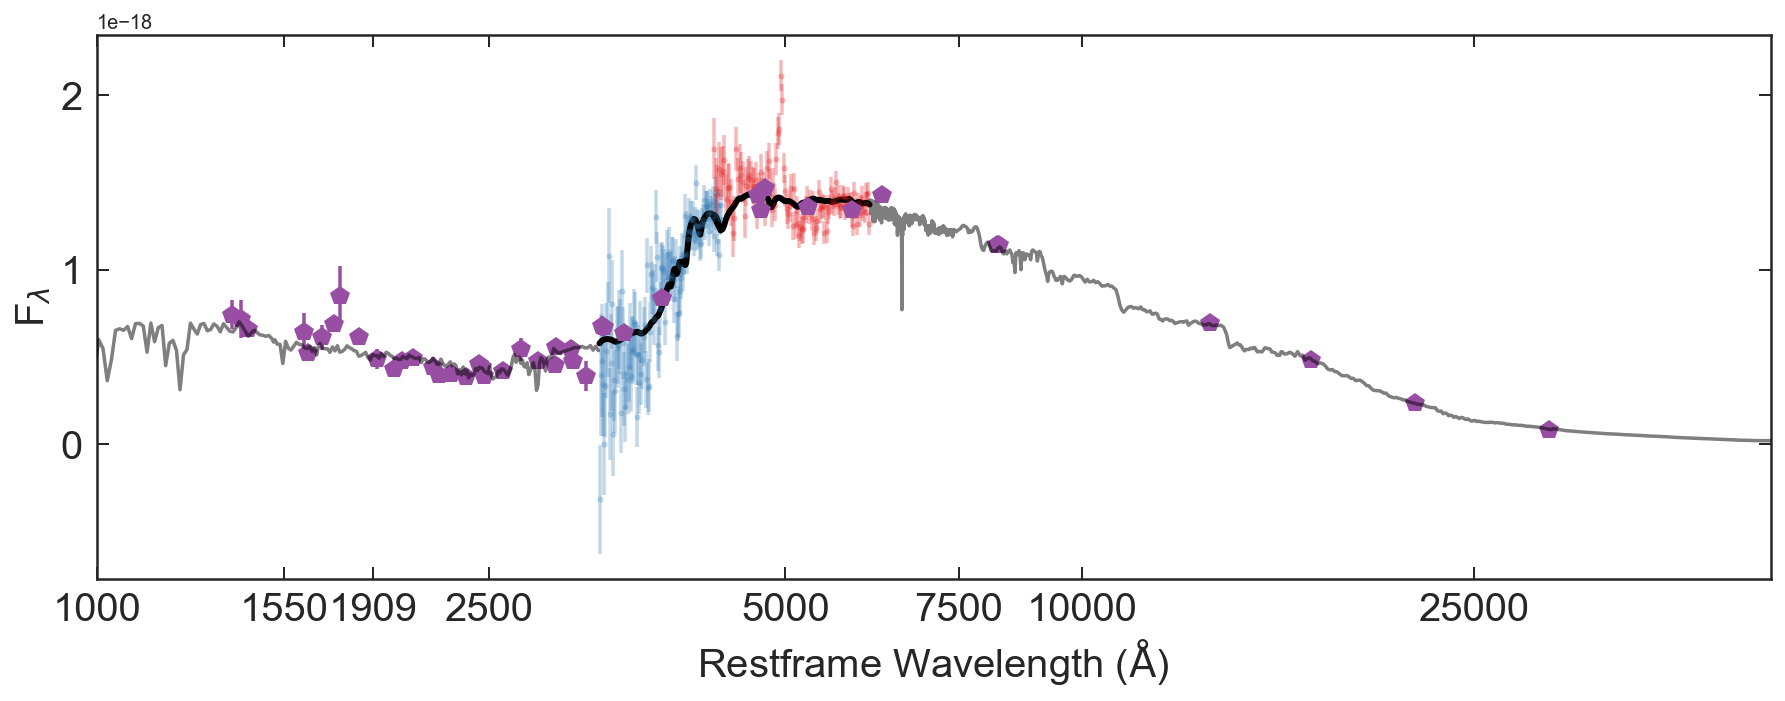

In [139]:
wv, fl = sp.get_spectrum(tage = 3.6, peraa = True)

Gs.Sim_all_test(wv*(1 + galDB.z_grism[idx]),fl*cal)

plt.figure(figsize=[10,5])
plt.errorbar(Gs.Bwv,Gs.Bflx,Gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Gs.Rwv,Gs.Rflx,Gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(Gs.Bwv,Gs.Bmfl,'k')
plt.plot(Gs.Rwv,Gs.Rmfl,'k')

plt.minorticks_off()
plt.xlim(8000, 16000)
plt.ylim(0,0.25E-17)
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

# sp2.params['gas_logz'] = -0.
# wv, fl = sp2.get_spectrum(tage =3.6, peraa = True)
# cal = Calzetti(0.6, wv)


plt.figure(figsize=[15,5])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bflx,Gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rflx,Gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl,'k',linewidth=3)
plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl,'k',linewidth=3)

IDb = [U for U in range(len(wv)) if wv[U] < Gs.Bwv_rf[0]]
IDr = [U for U in range(len(wv)) if wv[U] > Gs.Rwv_rf[-1]]

plt.plot(np.log10(wv[IDb]),Gs.PC * fl[IDb]*cal[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(wv[IDr]),Gs.PC * fl[IDr]*cal[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,1550,1909,2500,5000,7500,10000,25000]),[1000,1550,1909,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylim()
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [76]:
Gs.Sim_all_test(wv*(1 + galDB.z_grism[idx]),fl*cal)
bfBmfl = Gs.Bmfl
bfRmfl = Gs.Rmfl

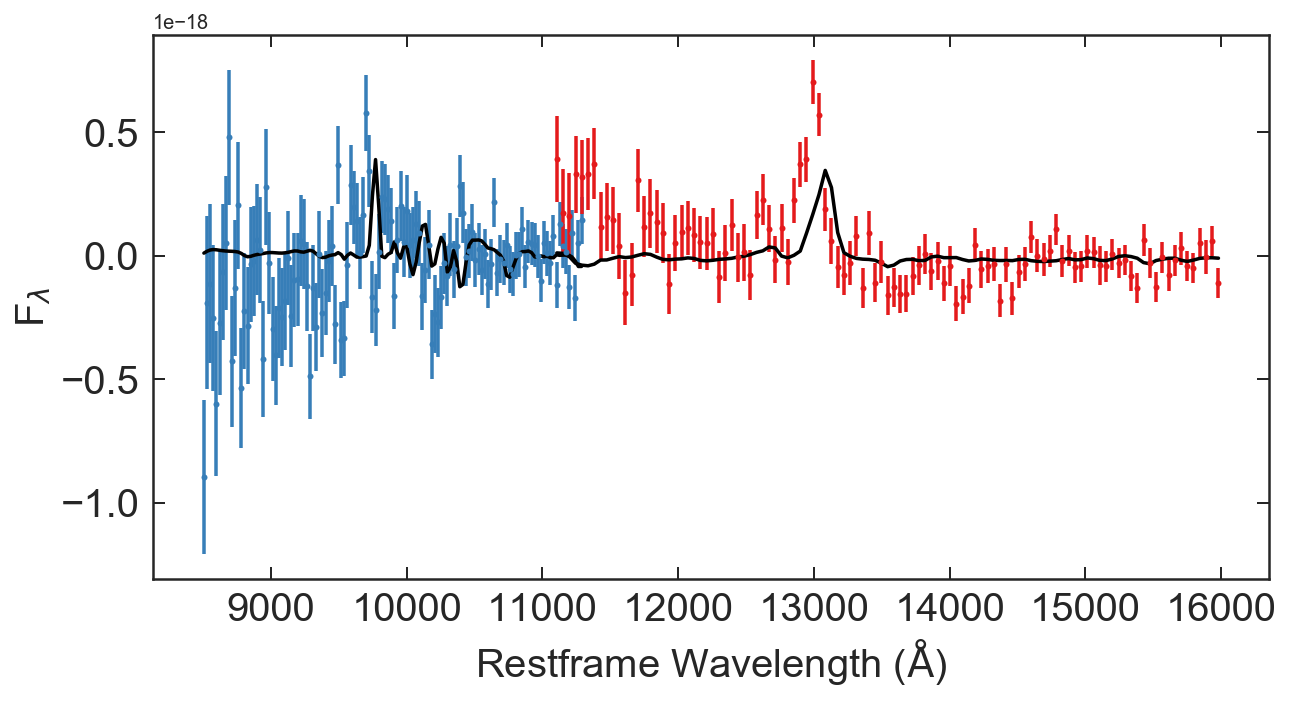

In [77]:
# sp2.params['gas_logz'] = -0.6
# wv2, fl2 = sp2.get_spectrum(tage = 3.6, peraa = True)

plt.figure(figsize=[10,5])
plt.errorbar(Gs.Bwv,Gs.Bflx - bfBmfl,Gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Gs.Rwv,Gs.Rflx - bfRmfl,Gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
Gs.Sim_all_test(wv2*(1 + galDB.z_grism[idx]),fl2*cal)
plt.plot(Gs.Bwv,Gs.Bpmfl - bfBmfl,'k')
plt.plot(Gs.Rwv,Gs.Rpmfl - bfRmfl,'k')

plt.minorticks_off()
plt.ylim()
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

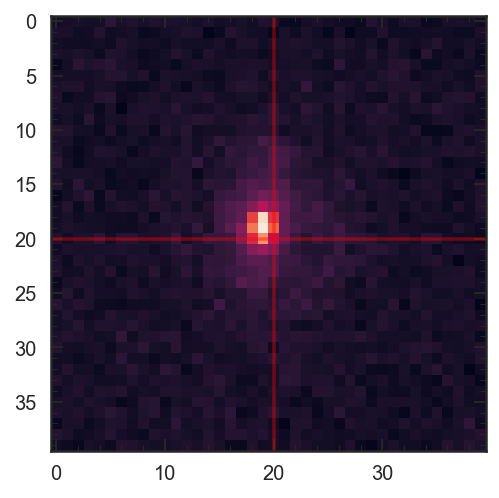

In [37]:
plt.imshow(Gs.Rbeam.beam.direct,vmin=-0.25E-20, vmax=4E-20)
plt.axvline(20,color='r',alpha=0.4)
plt.axhline(20,color='r',alpha=0.4)

In [95]:
age = np.arange(0.1,4,0.1)
gm =np.arange(-4,1,0.1)
Tchi = 1E5

for i in range(len(gm)):
    sp.params['gas_logz'] = gm[i]
    sp2.params['gas_logz'] = gm[i]
    for ii in range(len(age)):
        wvc, flc = sp.get_spectrum(tage = age[ii], peraa = True)
        wv, fl = sp2.get_spectrum(tage = age[ii], peraa = True)
        Gs.Sim_all_test(wvc*(1 + 1.608),flc)
        Bcont = Gs.Bpmfl
        Rcont = Gs.Rpmfl
        
        Gs.Sim_all_test(wv*(1 + 1.608),fl)

        Rchi1 = Chi_Squared(Gs.Rflx- bfRmfl, Gs.Rpmfl- Rcont, Gs.Rerr)
        Bchi1 = Chi_Squared(Gs.Bflx - bfBmfl, Gs.Bpmfl- Bcont, Gs.Berr)

        Tchi1 = Rchi1 + Bchi1
        if Tchi1 < Tchi:
            Tchi = Tchi1
            print(gm[i],age[ii],Tchi)

-4.0 0.1 436.72816160160073
-1.8999999999999981 0.1 431.16419930326424
-1.799999999999998 0.1 422.95637133117475
-1.699999999999998 0.1 413.1835682668109
-1.5999999999999979 0.1 401.6972984734376
-1.4999999999999978 0.1 388.44377717335806
-1.3999999999999977 0.1 376.91627568053354
-1.2999999999999976 0.1 364.47521638734554
-1.1999999999999975 0.1 351.6478329926939
-1.0999999999999974 0.1 339.41763071761943
-1.0999999999999974 1.3000000000000003 338.93674484194946
-1.0999999999999974 1.4000000000000001 338.51930339201255
-1.0999999999999974 1.5000000000000002 338.2772578472544
-0.9999999999999973 0.1 329.5075341305578
-0.9999999999999973 0.9 328.52798764254123
-0.9999999999999973 1.0 327.5370076668229
-0.9999999999999973 1.1 326.5928511320716
-0.9999999999999973 1.2000000000000002 325.7308618414744
-0.9999999999999973 1.3000000000000003 324.9853416946436
-0.9999999999999973 1.4000000000000001 324.3681884438631
-0.9999999999999973 1.5000000000000002 323.9107203749168
-0.9999999999999973 

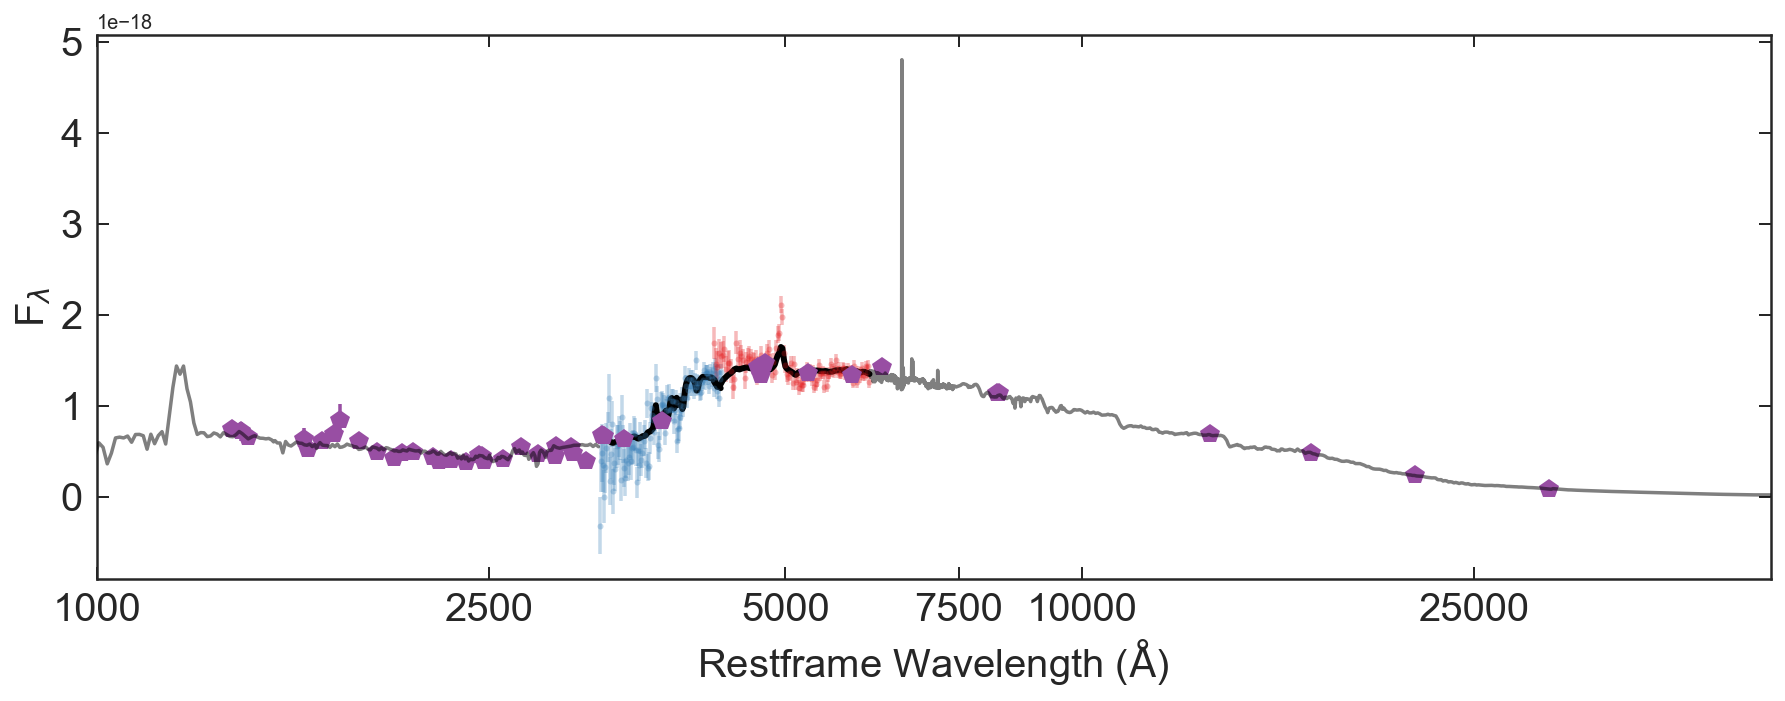

In [80]:
sp2.params['gas_logz'] = -0.
wv, fl = sp2.get_spectrum(tage =3.6, peraa = True)
cal = Calzetti(0.6, wv)

Gs.Sim_all_test(wv*(1 + 1.608),fl*cal)

plt.figure(figsize=[15,5])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bflx,Gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rflx,Gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf),(Gs.Bmfl+Gs.Bpmfl)/2,'k',linewidth=3)
plt.plot(np.log10(Gs.Rwv_rf),(Gs.Rmfl+Gs.Rpmfl)/2,'k',linewidth=3)

# plt.plot(np.log10(Gs.Bwv_rf),Gs.Bpmfl,'k',linewidth=3)
# plt.plot(np.log10(Gs.Rwv_rf),Gs.Rpmfl,'k',linewidth=3)

IDb = [U for U in range(len(wv)) if wv[U] < Gs.Bwv_rf[0]]
IDr = [U for U in range(len(wv)) if wv[U] > Gs.Rwv_rf[-1]]

plt.plot(np.log10(wv[IDb]),Gs.PC * fl[IDb]*cal[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(wv[IDr]),Gs.PC * fl[IDr]*cal[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylim()
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

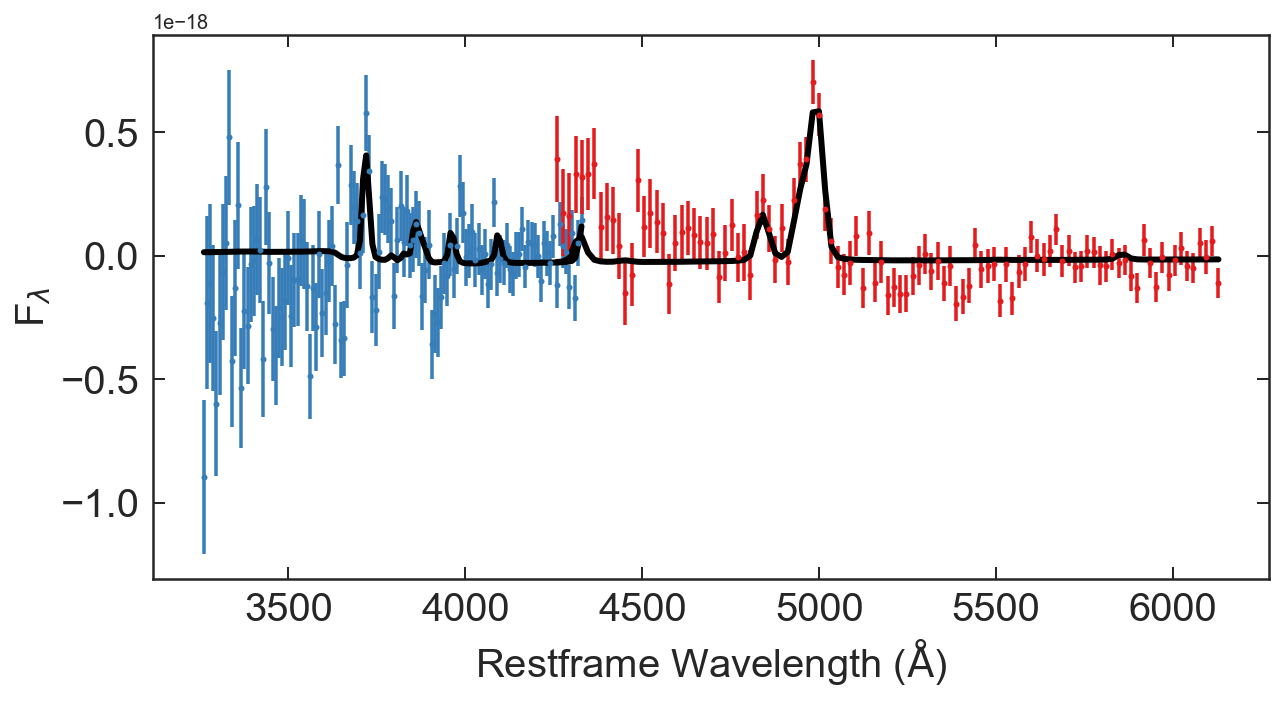

In [126]:
# sp.params['gas_logz'] = -0.7
# sp2.params['gas_logz'] = -0.7

# wvc, flc = sp.get_spectrum(tage =1.7, peraa = True)
# wv, fl = sp2.get_spectrum(tage = 1.7, peraa = True)
# Gs.Sim_all_test(wvc*(1 + 1.608),flc)
# Bcont = Gs.Bpmfl
# Rcont = Gs.Rpmfl

Gs.Sim_all_test(wv*(1 + 1.608),fl)

plt.figure(figsize=[10,5])
plt.errorbar(Gs.Bwv/ 2.608,Gs.Bflx - bfBmfl,Gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Gs.Rwv/ 2.608,Gs.Rflx - bfRmfl,Gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(Gs.Bwv/ 2.608,Gs.Bpmfl-Bcont,'k', linewidth=3)
plt.plot(Gs.Rwv/ 2.608,Gs.Rpmfl-Rcont,'k', linewidth=3)

plt.minorticks_off()
plt.ylim()
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


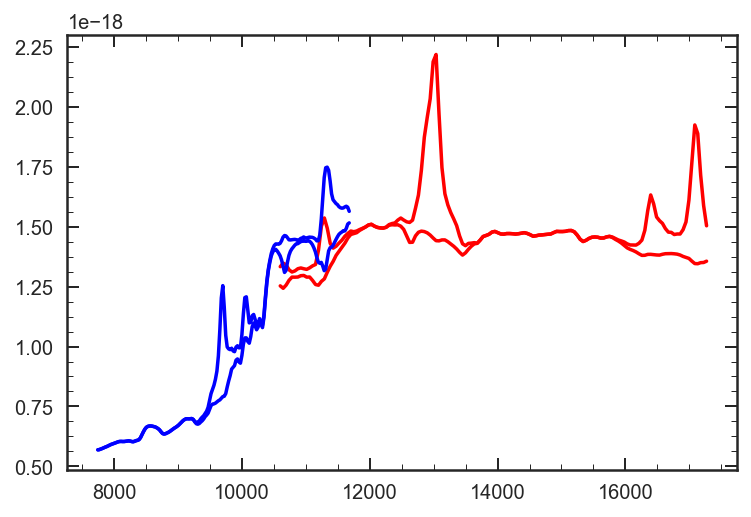

In [133]:
plt.plot(wave1,line1 / flat1,'r')
plt.plot(wave1,cont1 / flat1,'r')

plt.plot(wave3,line3 / flat3,'b')
plt.plot(wave3,cont3 / flat3,'b')


In [44]:
spec1=fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_44824.1D.fits')
spec2=fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_44824.1D.fits')


In [45]:
wave1 = np.array(spec1['G141'].data['wave']).T
flux1 = np.array(spec1['G141'].data['flux']).T
err1 = np.array(spec1['G141'].data['err']).T
flat1 = np.array(spec1['G141'].data['flat']).T
line1 = np.array(spec1['G141'].data['line']).T
cont1 = np.array(spec1['G141'].data['cont']).T

wave2 = np.array(spec2['G141'].data['wave']).T
flux2 = np.array(spec2['G141'].data['flux']).T
err2= np.array(spec2['G141'].data['err']).T
flat2 = np.array(spec2['G141'].data['flat']).T
line2 = np.array(spec2['G141'].data['line']).T
cont2 = np.array(spec2['G141'].data['cont']).T

wave3 = np.array(spec2['G102'].data['wave']).T
flux3 = np.array(spec2['G102'].data['flux']).T
err3= np.array(spec2['G102'].data['err']).T
flat3 = np.array(spec2['G102'].data['flat']).T
line3 = np.array(spec2['G102'].data['line']).T
cont3 = np.array(spec2['G102'].data['cont']).T

<ErrorbarContainer object of 3 artists>

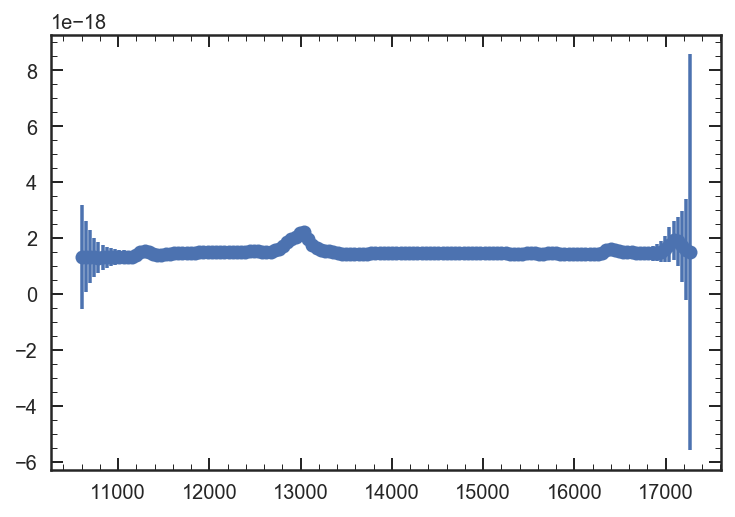

In [104]:
plt.errorbar(wave1,line1 / flat1,err1/flat1,fmt='o')

<ErrorbarContainer object of 3 artists>

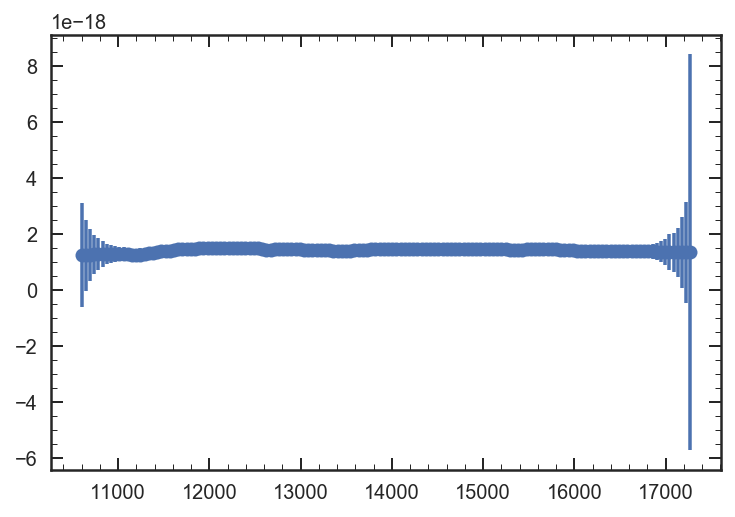

In [105]:
plt.errorbar(wave1,cont1 / flat1,err1/flat1,fmt='o')

In [115]:
FLX1 = flux1 / flat1
FLX2 = flux2 / flat2
ERR1 = err1 / flat1
ERR2 = err2 / flat2

In [116]:
FLX3 = FLX1*(1/ERR1**2)/(1/ERR1**2) + FLX2*(1/ERR2**2)/(1/ERR2**2)

In [122]:
flgrid = np.array([FLX1,FLX2]).T
weigrid = 1 / np.array([ERR1,ERR2]).T**2
#### Stack spectra
FLX3, ERR3 = np.zeros([2, len(flux1)])
for i in range(len(flux1)):
    FLX3[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
    ERR3[i] = 1 / np.sqrt(np.sum(weigrid[i]))

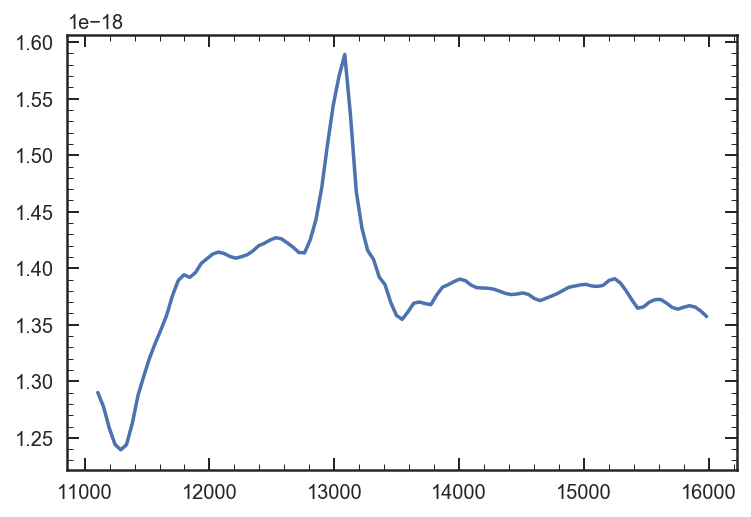

In [129]:
plt.plot(Gs.Rwv,Gs.Rmfl)

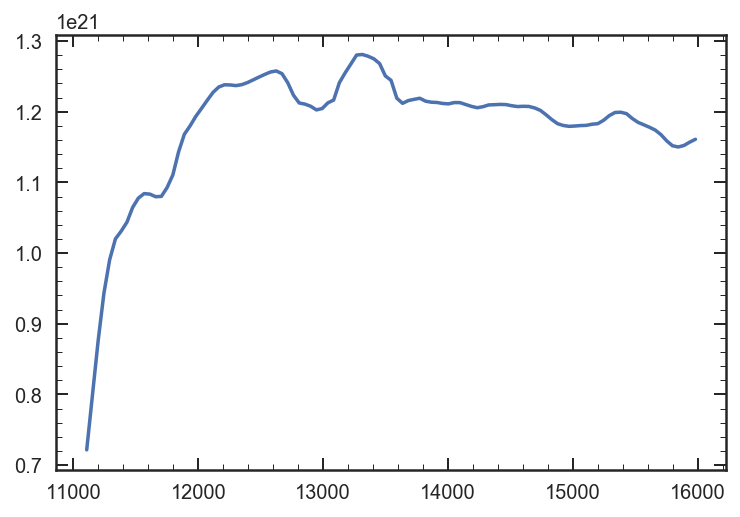

In [166]:
Gs.Sim_all_test(wv*(1 + galDB.z_grism[idx]),fl*cal)
plt.plot(Gs.Rwv,Gs.Rmfl)

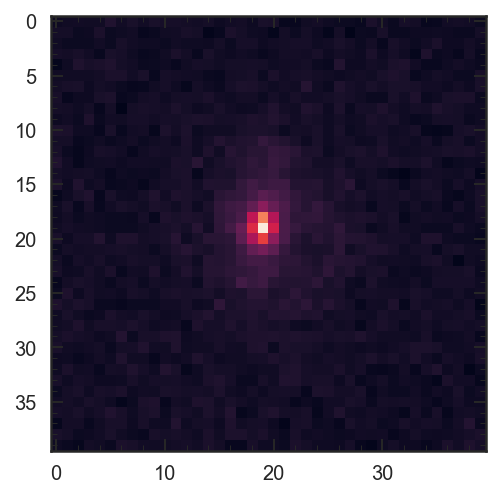

In [155]:
plt.imshow(Gs.Rbeam.beam.direct)

In [161]:
img = np.zeros(Gs.Rbeam.beam.direct.shape).astype(np.float32)

In [163]:
img[20:30,20:30] = np.ones(img[20:30,20:30].shape).astype(np.float32)

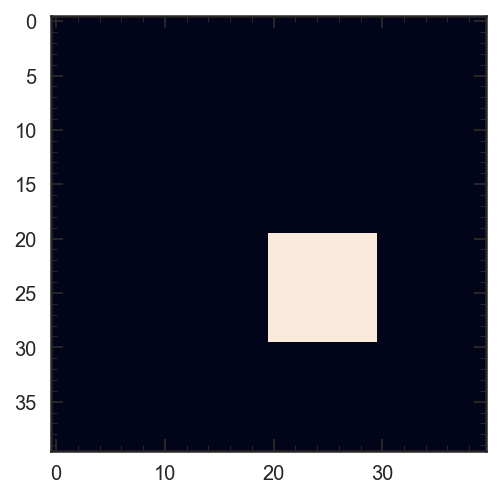

In [164]:
# mod = np.max(Gs.Rbeam.beam.direct)

plt.imshow(img/mod)

In [165]:
Gs.Rbeam.beam.direct = img/mod